# **Statistics Lab 52568 - Final Report** Lahav Rom & Raanan Vaknine

In [13]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw
code."></form>''')

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
from matplotlib import pyplot as plt
import random
import statsmodels.api as sm
import io
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [ ]:
run_in_colab = False
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Loading elections 2020 and 2021 data - ballot and cities:
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

**Question A**

לשם ניתוח הבחירות, השתמשנו במספר קבצים מהאתר של ועדת הבחירות המרכזית הרלוונטיים לבחירות לכנסת ה23 וה24. ייצאנו את קבצי האקסל שמופיעים באתר ומשקפים את התוצאות לפי קלפיות ולפי יישובים. בנוסף, השתמשנו בקובץ המראה את התוצאות לפי אשכול חברתי כלכלי כדי להיות מסוגלים לאפיין נתוני הצבעה לפי נתונים דמוגרפיים.
לצורך ניתוח הנתונים, ראשית ניקינו את הדאטה כלומר הסרנו ממאגר הנתונים עמודות ושורות לא רלוונטיות בהתאם לדרישות התרגיל. 
כלומר לעתים הסרנו שורות כדוגמת המעטפות החיצוניות כשאלו לא היו רלוונטיות לתרגיל. 
בנוסף, ברוב הסעיפים לקחנו רק את 13 המפלגות שעברו את אחוז החסימה בבחירות לכנסת ה24, ובבחירות לכנסת ה23 את 9 המפלגות הגדולות ואותן פיצלנו עפ״י נוסחה שנקבעה מראש כדי שיתאימו ל13 המפלגות שעברו את אחוז החסימה בבחירות לכנסת ה23.
להלן דוגמא למאגרי הנתונים בהם השתמשנו עבור ניתוח הבחירות לכנסת ה24 לאחר עיבוד וניקוי הנתונים, עבור מאגר הנתונים של התוצאות לפי יישובים.

**תוצאות לפי יישובים**

In [18]:
parties_dict_2021 = {'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה"
     , 'ט'  : "הציונות הדתית",'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"}
df_2021_city_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2021_city_raw.rename(columns=parties_dict_2021, inplace=True)
df_2021_city_raw = df_2021_city_raw[df_2021_city_raw.columns[:-1]]
df_city_2021 = df_2021_city_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019

df_city_2021 = df_city_2021[parties_dict_2021.values()]
df_city_2021.head()


,עבודה,מרצ,יהדות התורה,רעם,תקוה חדשה,הרשימה המשותפת,ימינה,הציונות הדתית,ישראל ביתנו,הליכוד,יש עתיד,כחול לבן,שס
שם ישוב,,,,,,,,,,,,,
אבירים,47,31,0,0,8,3,0,2,2,5,27,16,1
אדירים,1,0,4,0,6,0,7,9,0,84,2,3,61
אושה,72,20,0,0,15,3,7,0,8,24,86,37,0
אחווה,14,10,0,0,8,0,4,4,3,27,37,36,2
איבים,0,0,0,0,0,0,4,10,0,17,0,5,1


**Question B**

המפלגה שאנחנו קיבלנו היא ׳תקווה חדשה׳. מפלגה זו הוקמה בין הבחירות לכנסת ה23 והבחירות לכנסת ה24. לכן, בהשוואה לבחירות 2020 כדי לדמות מצב בו המפלגה היתה קיימת אז, לקחנו 16.7% מקולות הליכוד והתייחסנו אליהם כאילו הצביעו לתקווה חדשה ב2020. מצורף הקוד בו השתמשנו לצורך פיצול המפלגות.

**תוצאות לפני פיצול**

In [19]:
parties_dict_2020 = {'אמת' : "עבודה גשר מרצ", 'ג' : "יהדות התורה", 'ודעם'  : "הרשימה המשותפת"
    , 'טב'  : "ימינה", 'נץ'  : "עוצמה יהודית", 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "כחול לבן", 'שס'  : "שס"}

df_2020_city_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2020_city_raw.rename(columns=parties_dict_2020, inplace=True)
df_2020_city_raw = df_2020_city_raw[df_2020_city_raw.columns[:-1]]
df_2020_city_raw = df_2020_city_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019

df_city_2020 = df_2020_city_raw[parties_dict_2020.values()]

def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par >= thresh]

parties_votes_percents(df_city_2020,0)

הליכוד            0.295775
כחול לבן          0.266892
הרשימה המשותפת    0.127173
שס                0.077167
יהדות התורה       0.060018
עבודה גשר מרצ     0.058497
ישראל ביתנו       0.057597
ימינה             0.052638
עוצמה יהודית      0.004243
dtype: float64

**תוצאות אחרי פיצול**

In [20]:
parties_dict_2020 = {'אמת' : "עבודה גשר מרצ", 'ג' : "יהדות התורה", 'ודעם'  : "הרשימה המשותפת"
    , 'טב'  : "ימינה", 'נץ'  : "עוצמה יהודית", 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "כחול לבן", 'שס'  : "שס"}

df_2020_city_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2020_city_raw.rename(columns=parties_dict_2020, inplace=True)
df_2020_city_raw = df_2020_city_raw[df_2020_city_raw.columns[:-1]]
df_2020_city_raw = df_2020_city_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019

df_city_2020 = df_2020_city_raw[parties_dict_2020.values()]

parties_2020 = df_city_2020.copy()

#splitting to עבודה and מרצ
parties_2020['מרצ'] = 0.5 *parties_2020['עבודה גשר מרצ']
parties_2020['עבודה'] = 0.5 *parties_2020['עבודה גשר מרצ']
parties_2020 = parties_2020.drop('עבודה גשר מרצ', axis=1)
#splitting to רעם and המשותפת
parties_2020['רעם'] = 0.4 *parties_2020['הרשימה המשותפת']
parties_2020['הרשימה המשותפת'] = 0.6 *parties_2020['הרשימה המשותפת']
#splitting to תקוה חדשה and הליכוד
parties_2020['תקוה חדשה'] = 0.167 *parties_2020['הליכוד']
parties_2020['הליכוד'] = 0.833 *parties_2020['הליכוד']
#splitting to כחול לבן and יש עתיד
parties_2020['יש עתיד'] = 0.667 *parties_2020['כחול לבן']
parties_2020['כחול לבן'] = 0.333 *parties_2020['כחול לבן']
#splitting to ימינה and הציונות הדתית
parties_2020['הציונות הדתית'] = 0.4*parties_2020['ימינה']
parties_2020['ימינה'] = 0.6 *parties_2020['ימינה']
parties_2020['הציונות הדתית'] = parties_2020['הציונות הדתית']  + parties_2020['עוצמה יהודית']
parties_2020 = parties_2020.drop('עוצמה יהודית', axis = 1)

parties_votes_percents(parties_2020,0)

הליכוד            0.246380
יש עתיד           0.178017
כחול לבן          0.088875
שס                0.077167
הרשימה המשותפת    0.076304
יהדות התורה       0.060018
ישראל ביתנו       0.057597
רעם               0.050869
תקוה חדשה         0.049394
ימינה             0.031583
עבודה             0.029248
מרצ               0.029248
הציונות הדתית     0.025298
dtype: float64

**Question C**

כדי לבדוק מה היה קורה אם כלל הבז״ב היו מצביעים השתמשנו בתיקון הבא:

Fixing the data to 100% votes:

Vi = kosher(i) / bzb(i)

כלומר, חילקנו את כלל הקולות הכשרים בבז״ב ואז חילקנו את כל הדאטה פריים שלנו בתוצאה כדי לתקן את הנתונים. חשוב לציין כי בתיקון שביצענו הנחנו כי ההסתברות לצאת להצביע זהה עבור כל יישוב. לאחר מכן, חישבנו את שיעור ההצבעה לתקוה חדשה כפי שנראה בבחירות עצמן אל מול שיעור ההצבעה כפי שהיה מתקבל אם כלל הבז״ב היו מצביעים.

**השוואת שיעורי ההצבעה לפי יישובים**

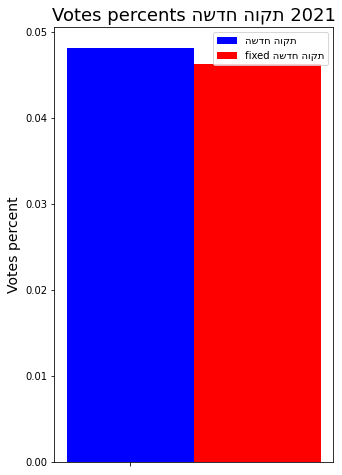

(<Figure size 360x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6850fe0d10>)

In [21]:
v = df_2021_city_raw['כשרים'].div(df_2021_city_raw['בזב'])
df_fix = df_city_2021.div(v , axis = 'rows')

# Bar plot for a party, only showing values above a certain threshold after fixing:
def party_bar_fix(df1, df2, thresh):
    width = 0.1  # set column width 
    votes = parties_votes_percents(df1, thresh)  # total votes for each party
    n = len(votes)  # number of parties
    names = votes.keys()
    fixed_votes = parties_votes_percents(df2, thresh)
    rev_names = [name[::-1] for name in list(names)]
    fig, ax = plt.subplots(figsize=(5,8))  # plt.subplots()
    all_bar = ax.bar(np.arange(1), votes['תקוה חדשה'], width, color='b')
    fix_bar = ax.bar(np.arange(1)+width, fixed_votes['תקוה חדשה'], width, color='r')
    ax.set_ylabel('Votes percent',fontsize=14)
    ax.set_title('Votes percents ' + 'תקוה חדשה'[::-1] + ' 2021',fontsize=18)
    ax.set_xticks(np.arange(1))
    ax.set_xticklabels('')
    ax.legend((all_bar[0], fix_bar[0]), ('תקוה חדשה'[::-1], 'fixed'+'תקוה חדשה '[::-1]))
    plt.show()

    return fig, ax

party_bar_fix(df_city_2021, df_fix, 0.035)

כפי שניתן לראות,כאשר מסתכלים על התוצאות לפי יישוב, אם כלל הבז״ב היו מצביעים, שיעור ההצבעה עבור מפלגת תקוה חדשה היה נמוך ממה שהתקבל בבחירות בפועל. בבחירות עצמן, שיעור ההצבעה למפלגת תקוה חדשה היה 4.81% בעוד אם היינו מתקנים את ההצבעות וכלל הבז״ב היו יוצאים להצביע שיעור ההצבעה הצפוי היה 4.62%.

כעת, לאחר שהצגנו את הנתונים עבור יישוב, נציג את הנתונים עבור הקלפיות

**השוואת שיעורי ההצבעה לפי קלפיות**

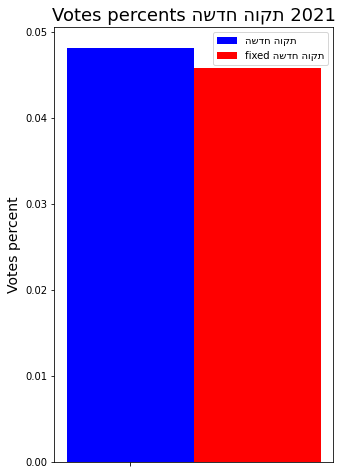

(<Figure size 360x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68503dc5d0>)

In [22]:
df_2021_ballot_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2021_ballot_raw.rename(columns=parties_dict_2021, inplace=True)
df_2021_ballot_raw = df_2021_ballot_raw[df_2021_ballot_raw.columns[:-1]]
df_2021_ballot_raw = df_2021_ballot_raw.drop('סמל ועדה', axis=1) 

df_ballot_2021 = df_2021_ballot_raw[parties_dict_2021.values()]
v_2 = df_2021_ballot_raw['כשרים'].div(df_2021_ballot_raw['בזב'])
df_fix_2 = df_ballot_2021.div(v_2 , axis = 'rows')

# Bar plot for a party, only showing values above a certain threshold after fixing:
def party_bar_fix(df1, df2, thresh):
    width = 0.1  # set column width 
    votes = parties_votes_percents(df1, thresh)  # total votes for each party
    n = len(votes)  # number of parties
    names = votes.keys()
    fixed_votes = parties_votes_percents(df2, thresh)
    rev_names = [name[::-1] for name in list(names)]
    fig, ax = plt.subplots(figsize=(5,8))  # plt.subplots()
    all_bar = ax.bar(np.arange(1), votes['תקוה חדשה'], width, color='b')
    fix_bar = ax.bar(np.arange(1)+width, fixed_votes['תקוה חדשה'], width, color='r')
    ax.set_ylabel('Votes percent',fontsize=14)
    ax.set_title('Votes percents ' + 'תקוה חדשה'[::-1] + ' 2021',fontsize=18)
    ax.set_xticks(np.arange(1))
    ax.set_xticklabels('')
    ax.legend((all_bar[0], fix_bar[0]), ('תקוה חדשה'[::-1], 'fixed'+'תקוה חדשה '[::-1]))
    plt.show()

    return fig, ax

party_bar_fix(df_ballot_2021, df_fix_2, 0.035)

כפי שניתן לראות,כאשר מסתכלים על התוצאות לפי קלפי, אם כלל הבז״ב היו מצביעים, שיעור ההצבעה עבור מפלגת תקוה חדשה היה נמוך ממה שהתקבל בבחירות בפועל. בבחירות עצמן, שיעור ההצבעה למפלגת תקוה חדשה היה 4.81% בעוד אם היינו מתקנים את ההצבעות וכלל הבז״ב היו יוצאים להצביע שיעור ההצבעה הצפוי היה 4.57%, כלומר נמוך אף יותר מהצפי לשיעור ההצבעה לפי יישוב.

**אחוז ההצבעה המשוער בקרב המצביעים הפוטנציאליים**

In [23]:
df_ballot_2021['תקוה חדשה'].sum()/df_fix_2['תקוה חדשה'].sum()

0.7059276570186398

כדי לחשב את שיעור ההצבעה בקרב התומכים של תקוה חדשה חישבנו את מספר האנשים שיצאו להצביע בפועל חלקי מספר האנשים שהיו מצביעים לתקווה חדשה אם כולם היו מצביעים (כלומר מספר התומכים של תקוה חדשה לאחר התיקון). קיבלנו שאחוז ההצבעה המשוער בקרב תומכי תקוה חדשה הוא 70.6%

**Question D**

ראשית, נתחיל בלהראות את שיעור ההצבעה לתקוה חדשה בכל אשכול חברתי כלכלי מתוך סך המצביעים לתקוה חדשה.
לאחר מכן נראה עבור כל אשכול את אחוז ההצבעה לכל מפלגה כדי לראות איך נראית תקוה חדשה ביחס לשאר המפלגות בכל אשכול.

**שיעור ההצבעה בכל אשכול מתוך סך המצביעים לתקוה חדשה לפי קובץ היישובים**

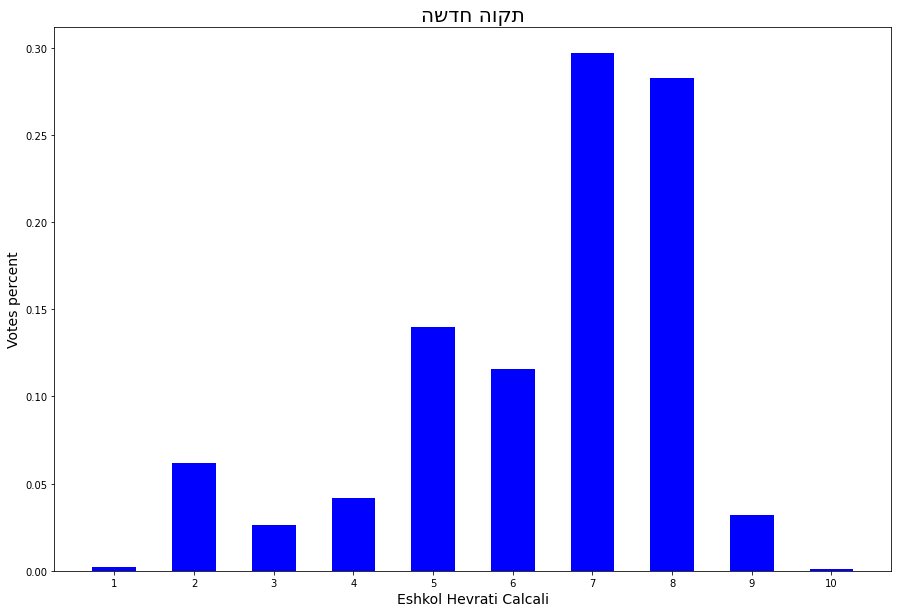

In [40]:
hevrati = pd.read_csv(io.BytesIO(uploaded['eshkol_hevrati_calcali.csv']),  encoding = 'iso-8859-8', index_col='set_code')
hevrati.rename(columns=parties_dict_2021, inplace=True)

df_2021_city_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8')
new_df = pd.merge(hevrati, df_2021_city_raw, how='inner', left_on='set_code', right_on='סמל ישוב').drop('name', axis='columns')

new_df = new_df.set_index('שם ישוב')

parties_df = new_df[parties_dict_2021]
parties_df['eco_level'] = new_df['eco_level']

def eshkol_votes_percents(v, thresh = 0):
    par = v.div(v.sum())
    return par[par > thresh]

grouped = parties_df.groupby('eco_level').sum()

fig, ax = plt.subplots(figsize=(15, 10)) 

votes = eshkol_votes_percents(grouped['ת'])
names = votes.keys()
ax.bar(np.arange(10), list(votes), 0.55, color='b')
ax.set_title('תקוה חדשה'[::-1],fontsize=20)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(names)
ax.set_ylabel('Votes percent',fontsize=14)
ax.set_xlabel('Eshkol Hevrati Calcali',fontsize=14)
plt.show()

כפי שניתן לראות בגרף, מרכזי הכובד של תקוה חדשה הינם באשכולות החזקים יחסית 7-8 אך הם מקבלים גם אחוזים לא קטנים מאשכולות 5-6.
חשוב לציין כי מאחר שתקוה חדשה חזקים יחסית באשכולות היותר מבוססים, מפתיע לגלות שכ7% מהקולות שקבלה המפלגה הגיעו מאשכול 2 החלש.
בנוסף, ניתן לראות כי המפלגה חלשה במיוחד באשכולות הקיצוניים 1 ו10 אך חשוב לציין כי האשכול ה10 הוא אשכול מצומצם במיוחד מבחינת מספר מצביעים.
בגרף זה, אין ערך מוסף בהצגת הנתונים לפי קלפיות שכן הסיווג הן של אשכול חברתי כלכלי והן של קלפי הוא לפי יישוב ולכן אין סיבה שנראה הבדל בתוצאות.

**אחוז ההצבעה לכל מפלגה בכל אשכול**

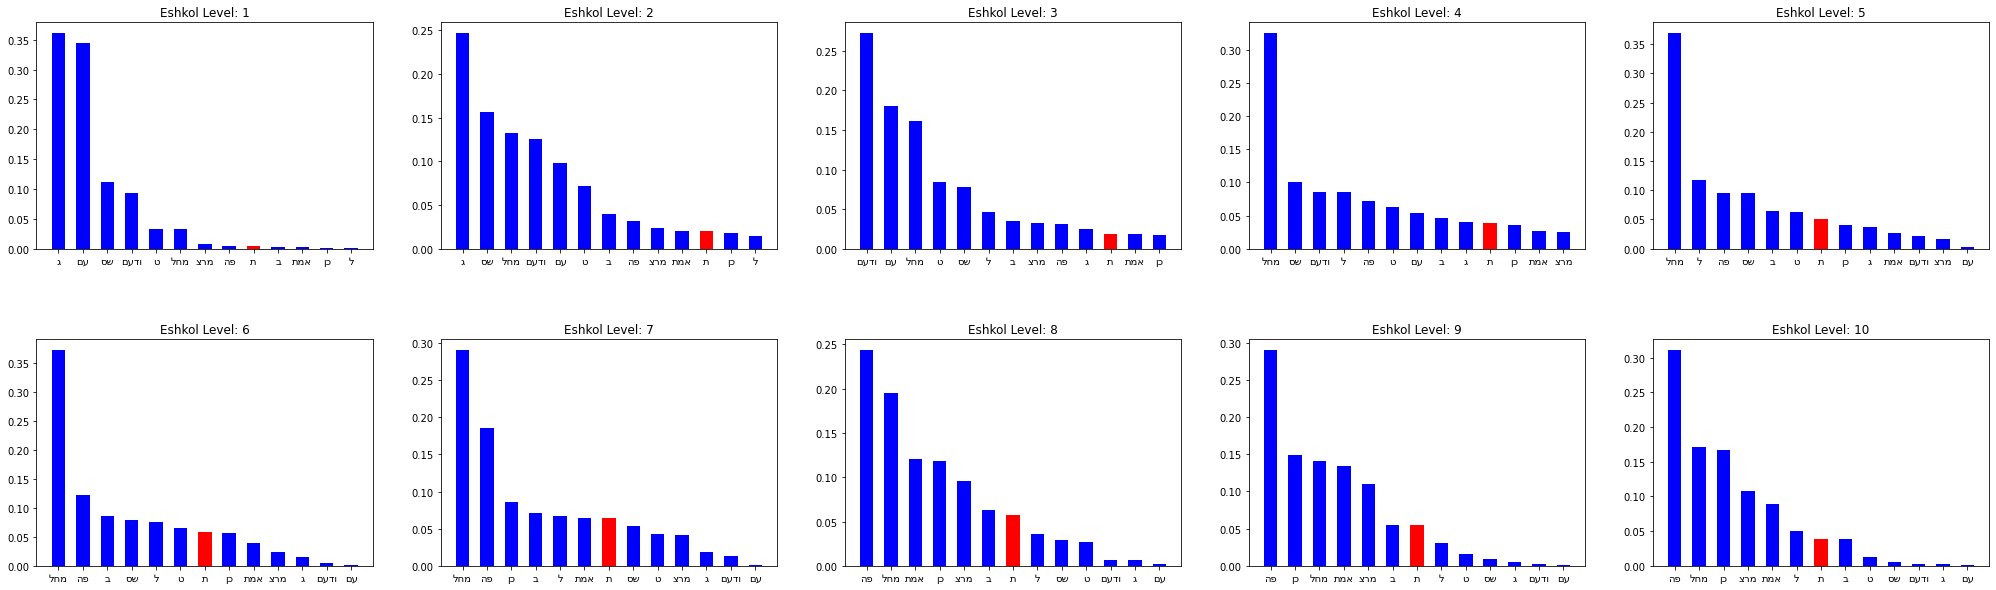

In [41]:
grouped = parties_df.groupby('eco_level')
fig, axs = plt.subplots(figsize=(35, 10), 
                        nrows=2, ncols=5,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec


targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
  votes = parties_votes_percents(grouped.get_group(key).drop('eco_level',axis='columns'), 0)
  names = votes.keys()
  rev_names = [name[::-1] for name in list(names)]
  ax.bar(np.arange(13), list(votes), 0.55, color=['r' if i == 'ת' else 'b' for i in rev_names])
  ax.set_title('Eshkol Level: ' + str(key))
  ax.set_xticks(np.arange(13))
  ax.set_xticklabels(rev_names)
plt.show()

כפי שניתן לראות בגרף זה בכ״א מהאשכולות 5-9 מפלגת תקוה חדשה המסומנת באדום בגרף היא המפלגה השביעית בגודלה מתוך 13 המפלגות שעברו את אחוז החסימה.

**Question E.1**

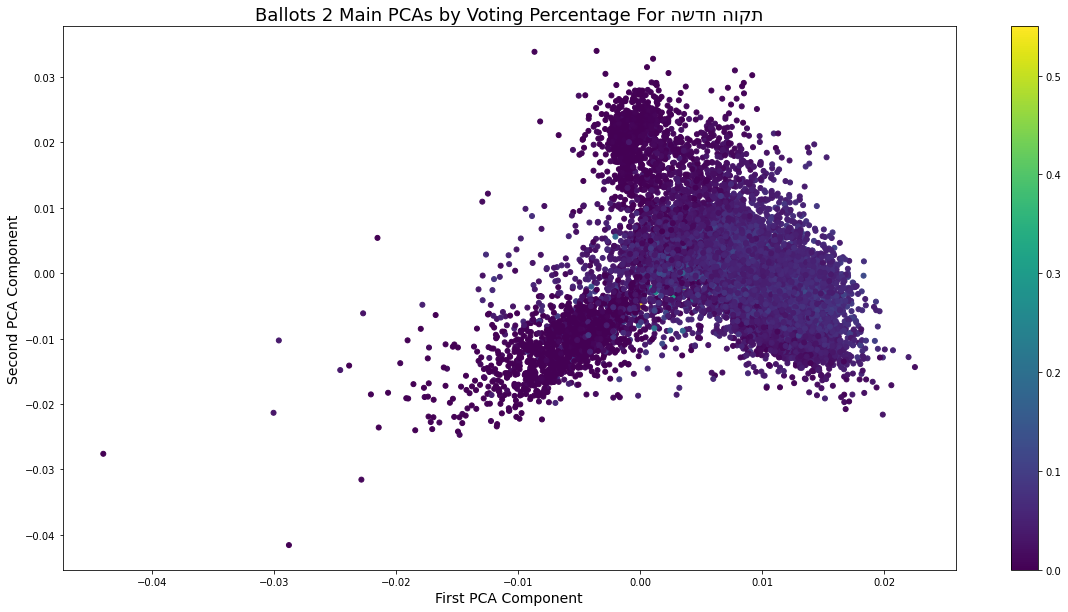

In [27]:
df_2021_raw_b = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')

df_2021_b = df_2021_raw_b.drop('סמל ועדה', axis=1) # new column added in Sep 2019
df_2021_b = df_2021_b[df_2021_b.columns[8:-1]] # removing "metadata" columns

df_2021_b.rename(columns=parties_dict_2021, inplace=True)
df_2021_b=df_2021_b.drop('כשרים',axis=1)

new_hope_per = []

for i in range(len(df_2021_b.index)):
  new_hope_per.append(df_2021_b.iloc[i]['תקוה חדשה']/(df_2021_b.iloc[i].sum()))

pca = PCA(n_components=2)  # define PCA object

normalized_df = df_2021_b.T.apply(lambda v: v/np.linalg.norm(v), axis = 'columns')

X_pca_norm = pca.fit_transform(normalized_df.dropna())  # fit model. Compute principal components
plt.scatter(pca.components_[0],pca.components_[1],c=new_hope_per, s=25)
plt.colorbar()
plt.title('Ballots 2 Main PCAs by Voting Percentage For ' + 'תקוה חדשה'[::-1],fontsize=18)
plt.xlabel('First PCA Component',fontsize=14)
plt.ylabel('Second PCA Component',fontsize=14)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()




**Question E.2**

In [28]:
parties_dict_2020 = {'אמת' : "עבודה גשר מרצ", 'ג' : "יהדות התורה", 'ודעם'  : "הרשימה המשותפת"
    , 'טב'  : "ימינה", 'נץ'  : "עוצמה יהודית", 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "כחול לבן", 'שס'  : "שס"}

df_2021_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2020_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')

df_2020_ballots_raw['מרצ'] = df_2020_ballots_raw['אמת']*0.5
df_2020_ballots_raw['אמת'] = df_2020_ballots_raw['אמת']*0.5
df_2020_ballots_raw['עם'] = df_2020_ballots_raw['ודעם']*0.4
df_2020_ballots_raw['ודעם'] = df_2020_ballots_raw['ודעם']*0.6
df_2020_ballots_raw['ת'] = df_2020_ballots_raw['מחל']*0.167
df_2020_ballots_raw['מחל'] = df_2020_ballots_raw['מחל']*0.833
df_2020_ballots_raw['ט'] = df_2020_ballots_raw['טב']*0.4 + df_2020_ballots_raw['נץ']
df_2020_ballots_raw['ב'] = df_2020_ballots_raw['טב']*0.6
df_2020_ballots_raw['כן'] = df_2020_ballots_raw['פה']*0.333
df_2020_ballots_raw['פה'] = df_2020_ballots_raw['פה']*0.667
df_2020_ballots_raw = df_2020_ballots_raw.drop(['טב','נץ'],axis = 1)

df_2020_ballots_raw = df_2020_ballots_raw.drop('Unnamed: 41',axis=1)
df_2020_b = df_2020_ballots_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
df_2020_b = df_2020_b[df_2020_b.columns[8:-1]] # removing "metadata" columns

df_2020_b.rename(columns=parties_dict_2020, inplace=True)
df_2020_b=df_2020_b.drop('כשרים',axis=1)

new_hope_diff = []

df_2020_ballots_raw.index = df_2020_ballots_raw.index + df_2020_ballots_raw['קלפי'].astype(str)
df_2021_ballots_raw.index = df_2021_ballots_raw.index + df_2021_ballots_raw['קלפי'].astype(str)

for i in range(len(df_2021_ballots_raw.index)):
  row = df_2020_ballots_raw[df_2020_ballots_raw.index  == df_2021_ballots_raw.iloc[i].name]
  if len(row) == 0:
    new_hope_diff.append(-0.1)
  else:
    new_hope_diff.append(abs(row['ת'].values[0]/(row[row.columns[10:-1]].values.sum())-df_2021_b.iloc[i]['תקוה חדשה']/(df_2021_b.iloc[i].sum())))


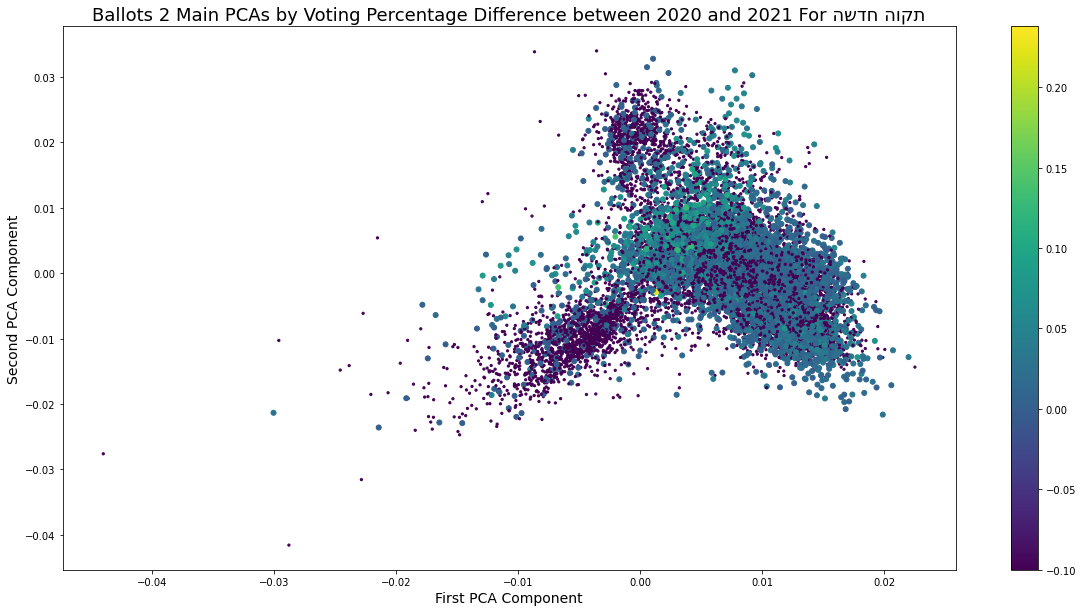

In [29]:
plt.scatter(pca.components_[0],pca.components_[1],c=[new_hope_diff], s=[5 if i == -0.1 else 25 for i in new_hope_diff])
plt.colorbar()
plt.title('Ballots 2 Main PCAs by Voting Percentage Difference between 2020 and 2021 For ' + 'תקוה חדשה'[::-1],fontsize=18)
plt.xlabel('First PCA Component',fontsize=14)
plt.ylabel('Second PCA Component',fontsize=14)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

חשוב לציין כי העיגולים הסגולים הכהים הקטנים שעבורם הערך המתאים הוא -0.1 מהווים קלפיות שנמצאות בבחירות 2021 אך לא נמצאות בבחירות 2020, זה נעשה כיוון שמיקומי הקלפיות בשני החלקים של סעיף זה עפ״י ההוראות צריכים להיות זהים אך עם צביעה שונה.

**Question F**

מאחר שקיבלנו את מפלגת תקוה חדשה, ומאחר שלא היתה קיימת ב2020 נבדוק את מטריצת המעבר עבור הליכוד בין בחירות 2020 לבחירות 2021

In [30]:
df_2021_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2020_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')

df_2021_ballots_raw.rename(columns=parties_dict_2021, inplace=True)

df_2021 = df_2021_ballots_raw[list(parties_dict_2021.values())+['בזב','קלפי']]

df_2021['לא הצביעו'] = df_2021['בזב'] - df_2021[df_2021.columns[:-2]].sum(axis=1)

df_2021 = df_2021.drop('מעטפות חיצוניות', axis = 'rows')

df_didnt_vote_2021 = df_2021.drop('בזב',axis=1)

df_2020_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2020_ballots_raw.rename(columns=parties_dict_2020, inplace=True)
df_2020 = df_2020_ballots_raw[list(parties_dict_2020.values())+['בזב','קלפי']]

df_2020['לא הצביעו'] = df_2020['בזב'] - df_2020[df_2020.columns[:-2]].sum(axis=1)
df_2020 = df_2020.drop('מעטפות חיצוניות', axis = 'rows')

df_didnt_vote_2020 = df_2020.drop('בזב',axis=1)

df_2020_2021 = pd.merge(df_didnt_vote_2020, df_didnt_vote_2021,how = 'inner', on=['קלפי','שם ישוב'],right_index = True,suffixes=('_2020', '_2021')).drop('קלפי',axis=1)

df_2020_new = df_2020_2021[df_2020_2021.columns[:10]]
df_2021_new = df_2020_2021[df_2020_2021.columns[10:]]
m_mat = pd.DataFrame(np.linalg.inv(df_2020_new.T.dot(df_2020_new)).dot(df_2020_new.T).dot(df_2021_new),columns=df_2021_new.columns,index=df_2020_new.columns)
m_mat = m_mat.applymap(lambda x: 0 if x < 0.005 else x)
m_mat = m_mat.div(m_mat.sum(axis = 1),axis = 0)
m_mat



,עבודה,מרצ,יהדות התורה_2021,רעם,תקוה חדשה,הרשימה המשותפת_2021,ימינה_2021,הציונות הדתית,ישראל ביתנו_2021,הליכוד_2021,יש עתיד,כחול לבן_2021,שס_2021,לא הצביעו_2021
עבודה גשר מרצ,0.455834,0.452631,0.000000,0.000000,0.000000,0.017615,0.000000,0.012435,0.000000,0.000000,0.000000,0.000000,0.015682,0.045803
יהדות התורה_2020,0.000000,0.000000,0.914421,0.000000,0.008015,0.000000,0.009236,0.037041,0.000000,0.000000,0.009547,0.000000,0.000000,0.021741
הרשימה המשותפת_2020,0.000000,0.014150,0.000000,0.273227,0.000000,0.329987,0.006005,0.000000,0.000000,0.022296,0.000000,0.000000,0.000000,0.354335
ימינה_2020,0.000000,0.000000,0.000000,0.000000,0.027192,0.000000,0.436286,0.536522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
עוצמה יהודית,0.032062,0.016365,0.000000,0.000000,0.000000,0.001707,0.000000,0.824369,0.006566,0.000000,0.000000,0.000000,0.000000,0.118931
ישראל ביתנו_2020,0.000000,0.000000,0.010288,0.000000,0.052096,0.026832,0.000000,0.000000,0.585651,0.000000,0.120696,0.000000,0.006693,0.197744
הליכוד_2020,0.000000,0.000000,0.000000,0.000000,0.065671,0.006145,0.079725,0.000000,0.000000,0.741148,0.000000,0.019298,0.005526,0.082487
כחול לבן_2020,0.086063,0.034600,0.000000,0.000000,0.089614,0.000000,0.050179,0.000000,0.016750,0.000000,0.483835,0.238959,0.000000,0.000000
שס_2020,0.012201,0.011213,0.016320,0.005864,0.000000,0.000000,0.000000,0.059548,0.000000,0.005206,0.000000,0.000000,0.800381,0.089267
לא הצביעו_2020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017809,0.011747,0.000000,0.000000,0.000000,0.970444


נראה בנוסף מפת חום של מטריצת המעבר

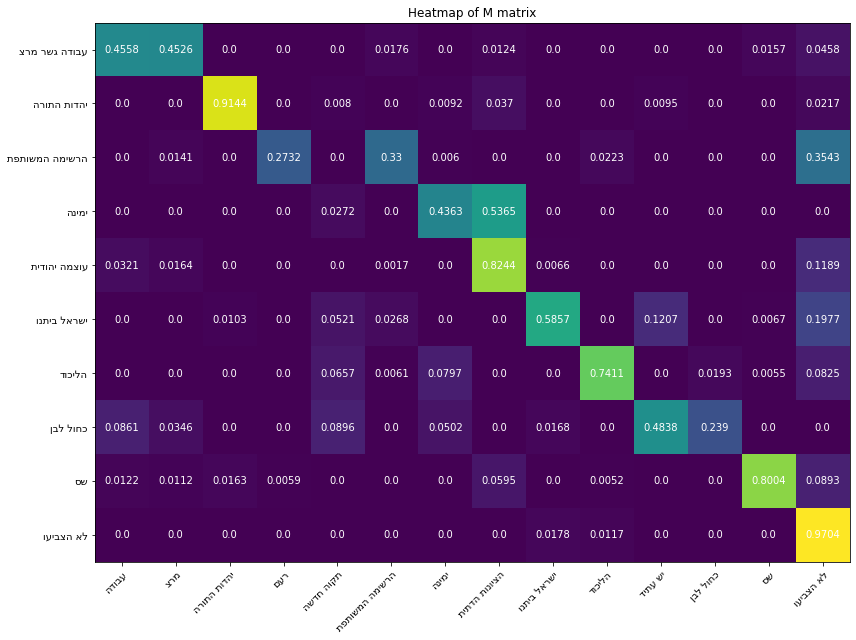

In [31]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(m_mat)
 
cols = m_mat.columns
rows = m_mat.index
# Show all ticks and label them with the respective list entries
ordered_rev_rows = [i.split('_')[0][::-1] for i in rows]
ordered_rev_cols = [i.split('_')[0][::-1] for i in cols]
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(rows)))
ax.set_xticklabels(ordered_rev_cols)
ax.set_yticklabels(ordered_rev_rows)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(rows)):
        text = ax.text(i,j, round(m_mat.iloc[j,i],4),ha="center", va="center",color="w")

ax.set_title("Heatmap of M matrix")
fig.tight_layout()
plt.show()

כעת, נראה רק את השורה הרלוונטית עבור הליכוד המשקפת את מעבר המצביעים מבחירות 2020 ל2021

In [32]:
m_mat[6:7]

,עבודה,מרצ,יהדות התורה_2021,רעם,תקוה חדשה,הרשימה המשותפת_2021,ימינה_2021,הציונות הדתית,ישראל ביתנו_2021,הליכוד_2021,יש עתיד,כחול לבן_2021,שס_2021,לא הצביעו_2021
הליכוד_2020,0.0,0.0,0.0,0.0,0.065671,0.006145,0.079725,0.0,0.0,0.741148,0.0,0.019298,0.005526,0.082487


כפי שניתן לראות, רובם הגדול של המצביעים נשאר בליכוד. באופן מפתיע הקבוצה הגדולה ביותר שלא נשארה בליכוד היא אלו שבחרו לא לצאת להצביע בבחירות 2021.
בנוגע למפלגת תקוה חדשה, נראה כי 6.6% ממצביעי הליכוד אכן עברו והצביעו למפלגת תקוה חדשה בבחירות 2021.
חשוב לציין כי 8% ממצביעי הליכוד ב2020 עברו והצביעו לימינה.

**Question G**

כדי לבדוק מאיפה מפלגת תקוה חדשה ב2021 קיבלה קולות נוספים, ניקח את העמודה של המפלגה בבחירות 2021 וננרמל אותה

In [33]:
m_mat['תקוה חדשה'].div(m_mat['תקוה חדשה'].sum())

עבודה גשר מרצ          0.000000
יהדות התורה_2020       0.033039
הרשימה המשותפת_2020    0.000000
ימינה_2020             0.112090
עוצמה יהודית           0.000000
ישראל ביתנו_2020       0.214750
הליכוד_2020            0.270711
כחול לבן_2020          0.369409
שס_2020                0.000000
לא הצביעו_2020         0.000000
Name: תקוה חדשה, dtype: float64

כפי שניתן לראות, הרוב המוחלט של הקולות שהתקבלו בתקוה חדשה בבחירות 2021 נובע ממעבר של מצביעי כחול לבן מ2020.בנוסף, מספר גדול של קולות הגיע כידוע מהליכוד וגם מישראל ביתנו וימינה.

**Question H**

ראשית, נחשב את מטריצת השאריות

In [34]:
res_mat = (df_2020_new.dot(m_mat)-df_2021_new)
res_mat.head()

,עבודה,מרצ,יהדות התורה_2021,רעם,תקוה חדשה,הרשימה המשותפת_2021,ימינה_2021,הציונות הדתית,ישראל ביתנו_2021,הליכוד_2021,יש עתיד,כחול לבן_2021,שס_2021,לא הצביעו_2021
שם ישוב,,,,,,,,,,,,,,
אבו גוש,0.021902,-2.285037,0.097920,33.527824,4.989472,-12.495335,6.954725,1.755485,4.706864,-34.516338,4.709030,3.285464,0.131149,-27.883126
אבו גוש,2.587017,-4.930576,0.032640,7.930412,3.191721,-13.231288,5.133328,1.616774,5.111360,-9.561264,-4.096990,2.205681,1.994296,0.016888
אבו גוש,2.967674,4.440645,0.753551,25.011593,2.527694,-23.077931,4.169264,0.709822,4.423899,-26.716095,4.020016,-0.586577,0.228774,-19.872327
אבו עבדון שבט,0.000000,0.565988,0.000000,-8.070909,0.000000,10.199492,0.240193,0.000000,1.816504,-1.909965,0.000000,0.000000,0.000000,-10.841303
אבו קרינאת יישוב,8.577777,8.608411,0.000000,-154.867997,2.884134,77.293611,4.870043,0.648438,5.305429,6.034592,23.159419,10.483738,-0.842286,-35.155311


שנית, עבור כל מפלגה נחשב את השגיאה הריבועית הממוצעת

$MSE(\hat{\theta}) = \mathbb{E}((\hat{\theta}-\theta)^2)$

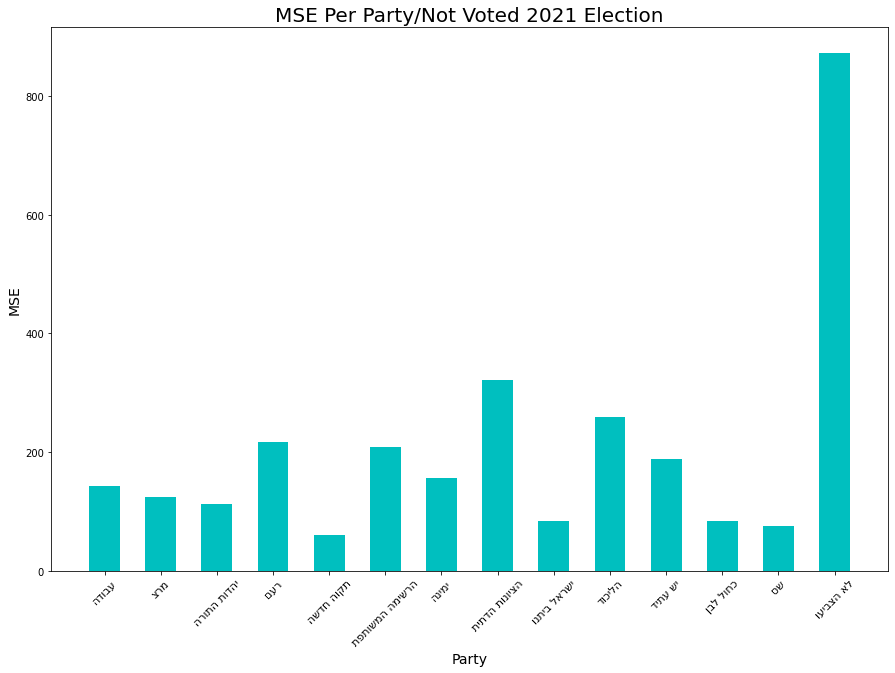

In [35]:
mse_per_party = pd.DataFrame(np.square(res_mat).mean(),columns = ['mse'])
fig, ax = plt.subplots(figsize=(15, 10)) 
rev = [i.split('_')[0][::-1] for i in list(mse_per_party.index)]
ax.bar(rev,mse_per_party['mse'], 0.55, color='c')
ax.set_title('MSE Per Party/Not Voted 2021 Election',fontsize=20)
ax.set_xticklabels(rev,rotation=45,fontsize = 11)
ax.set_ylabel('MSE',fontsize=14)
ax.set_xlabel('Party',fontsize=14)
plt.show()

 ניתן לראות כי ללא מצביעים יש השפעה גדולה על הבחירות. הדבר נובע מכך שלאוכלוסיית הלא מצביעים השגיאה הריבועית הממוצעת הגבוהה ביותר כלומר החיזוי שלנו עבור אוכלוסייה זו הוא החלש ביותר. כלומר יש להם את היכולת לשנות את תוצאות הבחירות.
חשוב לציין כי גם לשס, ישראל ביתנו ויהדות התורה יש שגיאה ריבועית ממוצעת נמוכה, הנ״ל נובע לדעתנו מכך שלמפלגות אלו יש בייס חזק מאוד שמתבטא גם מבחינת דמוגרפית וגאוגרפית כלומר קל יותר לחזות את מעבר המצביעים בין הבחירות עבור מפלגות אלו עקב העובדה כי לאותן קלפיות יש סיכוי גבוה להצביע בבחירות הבאות בצורה דומה.
בנוסף, למפלגת תקוה חדשה השגיאה הריבועית הממוצעת הקטנה ביותר.

**Question I**

כדי למצוא קלפיות חריגות, נתחיל בלאתר קלפיות בהן שיעור ההצבעה הכללי עבור מפלגת תקוה חדשה היה גבוה ביחס לאחוז הבחירה משוער למפלגת תקוה חדשה בבחירות 2020 , כלומר לאחר התיקון כאשר לוקחים מצביעים מהליכוד.
נוציא את 10 הקלפיות עבורם אירע בין בחירות 2020 לבחירות 2021 השינוי הגדול ביותר בהצבעה עבור תקוה חדשה, בערך מוחלט.

In [36]:
df_2021_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2020_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2021_ballots_raw.rename(columns=parties_dict_2021, inplace=True)
df_2021_ballots_raw = df_2021_ballots_raw[df_2021_ballots_raw.columns[:-1]]

df_2020_ballots_raw.rename(columns=parties_dict_2020, inplace=True)
df_2020_ballots_raw = df_2020_ballots_raw[df_2020_ballots_raw.columns[:-1]]


df_2020_ballot = df_2020_ballots_raw.reset_index()
df_2021_ballot = df_2021_ballots_raw.reset_index()

ballot_match = df_2020_ballot.set_index(['קלפי', 'סמל ישוב','שם ישוב']).join(df_2021_ballot.set_index(['קלפי', 'סמל ישוב','שם ישוב']), lsuffix = '-2020' , how='inner')

#ballot_match = ballot_match.drop(['Unnamed: 41','Unnamed: 50'],axis=1)
ballot_2021 = ballot_match[ballot_match.columns[len(df_2020_ballot.columns)-3:]]
ballot_2020 = ballot_match[ballot_match.columns[0:len(df_2020_ballot.columns)-3]]
ballot_2020.columns = df_2020_ballot.set_index(['קלפי', 'סמל ישוב','שם ישוב']).columns

parties_2020 = ballot_2020.copy()

#splitting to עבודה and מרצ 
parties_2020['מרצ'] = 0.5 *parties_2020['עבודה גשר מרצ']
parties_2020['עבודה'] = 0.5 *parties_2020['עבודה גשר מרצ']
parties_2020.drop('עבודה גשר מרצ', axis=1)
#splitting to רעם and המשותפת
parties_2020['רעם'] = 0.4 *parties_2020['הרשימה המשותפת']
parties_2020['הרשימה המשותפת'] = 0.6 *parties_2020['הרשימה המשותפת']
#splitting to תקוה חדשה and הליכוד
parties_2020['תקוה חדשה'] = 0.167 *parties_2020['הליכוד']
parties_2020['הליכוד'] = 0.833 *parties_2020['הליכוד']
#splitting to כחול לבן and יש עתיד
parties_2020['יש עתיד'] = 0.667 *parties_2020['כחול לבן']
parties_2020['כחול לבן'] = 0.333 *parties_2020['כחול לבן']
#splitting to ימינה and הציונות הדתית
parties_2020['הציונות הדתית'] = 0.4*parties_2020['ימינה']
parties_2020['ימינה'] = 0.6 *parties_2020['ימינה']
parties_2020['הציונות הדתית'] = parties_2020['הציונות הדתית']  + parties_2020['עוצמה יהודית']
parties_2020.drop('עוצמה יהודית', axis = 1)

parties_2020 = parties_2020[parties_2020.columns[8:]]
parties_2020 = parties_2020.div(parties_2020.sum(axis = 1), axis = 0)

parties_2021 = ballot_2021.copy()

parties_2021 = parties_2021[parties_2021.columns[8:]]
parties_2021 = parties_2021.div(parties_2021.sum(axis = 1), axis= 0)
new_hope_df = pd.DataFrame({'תקוה חדשה 2021': parties_2021['תקוה חדשה'],'תקוה חדשה 2020': parties_2020['תקוה חדשה']})

df = pd.DataFrame(abs(new_hope_df['תקוה חדשה 2021']-new_hope_df['תקוה חדשה 2020']).nlargest(10),columns = ['Absolute Distance'])
df



Absolute Distance
קלפי סמל ישוב שם ישוב                      
1.0  868      אלוני יצחק           0.241600
3.0  4501     עגר                  0.231360
90.0 2200     דימונה               0.180479
1.0  4502     עין קנייא            0.151794
     4501     עגר                  0.149035
     1365     אליאב                0.143055
     4019     מיצר                 0.131598
     338      איבים                0.129889
     102      מאיר שפיה            0.126953
     2057     שדי תרומות           0.123954

כעת, נציג את אחוזי ההצבעה עבור תקוה חדשה בכל אחד מהקלפיות הבעייתיות ב2020 וב2021

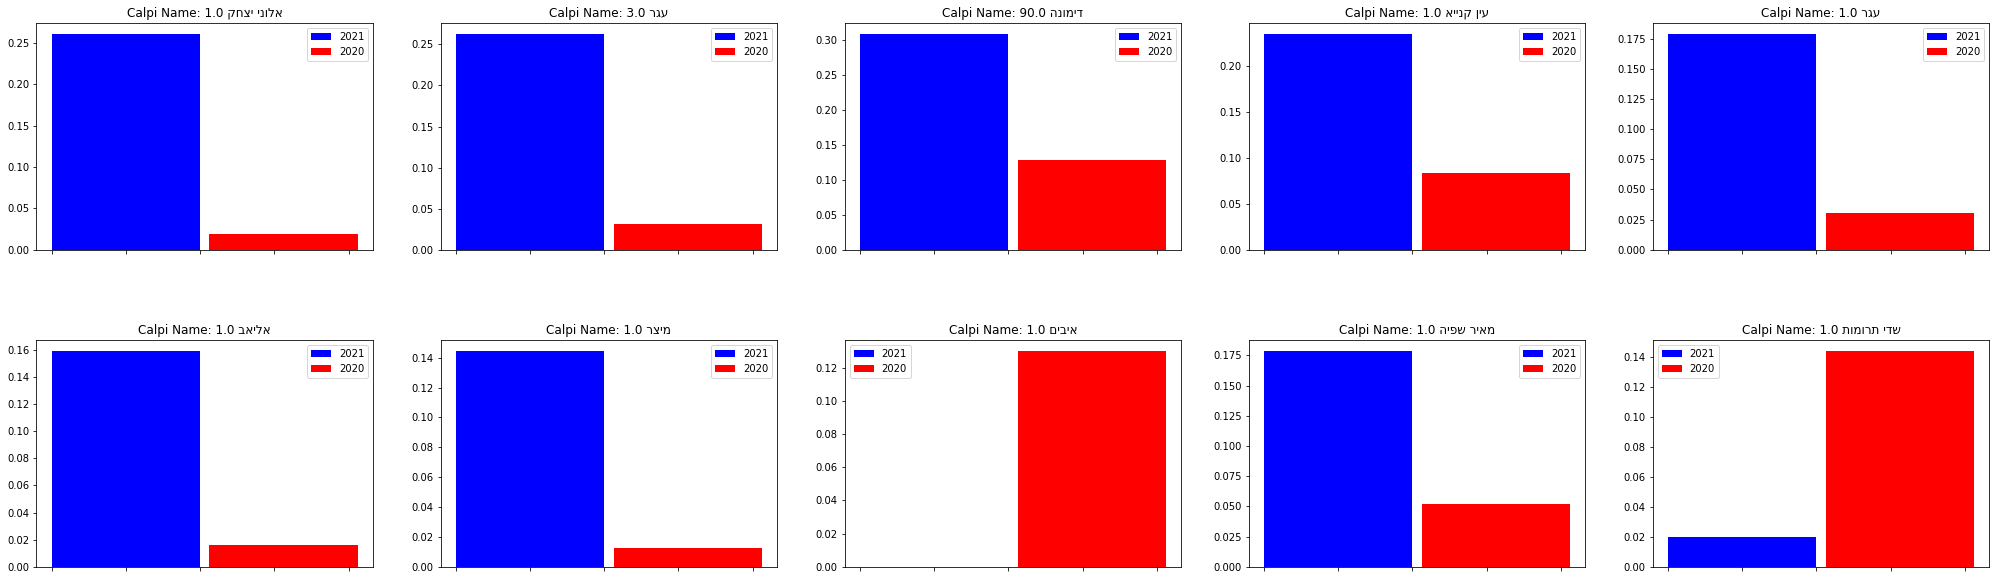

In [37]:
parties_2021 = parties_2021[parties_dict_2021.values()]
parties_2020 = parties_2020[parties_dict_2021.values()]

top_10_2021 = parties_2021.loc[df.index]
top_10_2020 = parties_2020.loc[df.index]

fig, axs = plt.subplots(figsize=(35, 10), 
                        nrows=2, ncols=5,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

width = 0.425
targets = zip(top_10_2021.index, axs.flatten())
for i, (key, ax) in enumerate(targets):
  names = top_10_2021.columns
  #rev_names = [name[::-1] for name in list(names)]
  rev_names = ['תקוה חדשה'][::-1]
  ax.bar(np.arange(1), top_10_2021.loc[key]['תקוה חדשה'], 0.4, color='b')
  ax.bar(np.arange(1) + width, top_10_2020.loc[key]['תקוה חדשה'], 0.4, color='r')
  ax.set_title('Calpi Name: ' + str(key[0]) + ' ' + str(key[2])[::-1])
  #ax.set_xticks('')
  ax.set_xticklabels(rev_names,rotation='vertical')
  ax.legend(('2021','2020'))
plt.show()

כפי שניתן לראות, אם ניקח לדוג׳ את היישובים איבים ושדי תרומות נראה כי ככה״נ מאחר שהיישובים הללו מצביעים לליכוד באופן מובהק, עקב החלוקה שאנו עושים בבחירות 2020 היינו מצפים שיצביעו לתקוה חדשה ב2021 כאשר בפועל בגלל שהם מצביעים לליכוד באופן מובהק,כמעט וכלל לא הצביעו לתקוה חדשה ב2021. בנוסף מפתיע כי שתי קלפיות מהיישוב המוסלמי ע׳ג׳ר נמצאות ברשימה כאשר נראה כי הרבה מתושביו הצביעו לתקוה חדשה.

כעת, ניקח מתוך הקלפיות המשותפות לבחירות 2020 ו2021 את הקלפיות החשודות כלומר קלפיות בהן שיעור הקולות הפסולים בבחירות 2020 הוא הגבוה ביותר. 

In [38]:
suspicious = pd.DataFrame((ballot_2020['פסולים']/ballot_2020['כשרים']).nlargest(10),columns = ['suspicious'])
suspicious

,,,suspicious
קלפי,סמל ישוב,שם ישוב,
71.1,9000,באר שבע,0.090164
19.0,1061,נוף הגליל,0.049738
83.0,8500,רמלה,0.049327
5.0,2630,קרית גת,0.048780
545.1,3000,ירושלים,0.045455
866.5,5000,תל אביב יפו,0.041139
76.0,9999,מעטפות חיצוניות,0.038519
1.0,102,מאיר שפיה,0.038462
501.3,3000,ירושלים,0.037313


נסתכל גם על הקלפיות בעלות שיעור הקולות הפסולים הגבוה ביותר בבחירות 2021

In [39]:
suspicious_2021 = pd.DataFrame((ballot_2021['פסולים']/ballot_2021['כשרים']).nlargest(10),columns = ['suspicious'])
suspicious_2021

,,,suspicious
קלפי,סמל ישוב,שם ישוב,
52.0,2710,אום אלפחם,0.071823
194.0,9999,מעטפות חיצוניות,0.060038
634.0,9999,מעטפות חיצוניות,0.057884
488.0,3000,ירושלים,0.057292
59.0,1061,נוף הגליל,0.052632
3.0,521,עין נקובא,0.050781
10.0,542,ריינה,0.049774
21.0,9600,קרית ים,0.048128
707.0,4000,חיפה,0.044444


נראה כי הקלפיות של ירושלים, חיפה ונוף הגליל בעלות שיעור פסולים מהגבוהים ביותר גם בבחירות 2020 וגם בבחירות 2021.